In [1]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load Data from Bugzilla (REST)

Here's a link to the [Bugzilla URL for Papyrus](https://bugs.eclipse.org/bugs/buglist.cgi?bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED&limit=0&list_id=17376363&order=priority%2Cbug_severity&product=Papyrus&query_format=advanced) (filtered on open bugs):

First we need to request the data based on our Bugzilla query. The initial response will only include overall bug information, so to retrieve the full bug text (with comments), an additional request is made for each bug.

We'll create a few arrays of data based on the bugs:
1. bug_ids - the text id of the bug
2. bug_titles - the title of the bug
3. bug_products - the product listed for the bug
4. bug_components - the component listed for the bug
5. bug_text - a concatenation of all of the text (including comments) entered for the bug

# REST Data Loading

This piece loads JSON formated data through a http GET request and parses it into the arrays described previously.

In [30]:
###
### Need to update this to pick up reporter and commenters
###
import requests

# Remove the limit=10 after debugging errors. Beware of rate limits. Eclipse Bugzilla automatically limits to 2000
resp = requests.get('https://bugs.eclipse.org/bugs/rest/bug?limit=10&product=Papyrus&bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

bugs = resp.json()
print('Loaded '+str(len(bugs['bugs']))+' bugs')


bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []
bug_reporter = []
bug_commenters = []

def getComments(id):
    url = 'https://bugs.eclipse.org/bugs/rest/bug/'+str(id)+'/comment'
    resp = requests.get(url)
    if resp.status_code != 200:
        # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    response = resp.json()
    
    text = ' '
    commenters = []
    for comment in response['bugs'][str(id)]['comments']:
        text += ' '+ comment['text']
        commenters.append(comment['creator'])
    
    bug_commenters.append(commenters)
    return text#, commenters
    
for bug in bugs['bugs']:
    print(bug)
    id = bug['id']
    bug_ids.append(id)
    
    summary = bug['summary']
    bug_titles.append(summary)
    product = bug['product']
    bug_products.append(product)
    
    component = bug['component']
    bug_components.append(component)
    
    text = summary + getComments(id)
    bug_text.append(text);    


Loaded 10 bugs
{'assigned_to_detail': {'name': 'mdt-papyrus-inbox@eclipse.org', 'email': 'mdt-papyrus-inbox@eclipse.org', 'id': 53712, 'real_name': 'Project Inbox'}, 'platform': 'All', 'op_sys': 'All', 'flags': [], 'is_cc_accessible': True, 'is_creator_accessible': True, 'whiteboard': '', 'deadline': None, 'is_open': True, 'classification': 'Modeling', 'is_confirmed': True, 'creator': 'cedric.dumoulin@lifl.fr', 'cc_detail': [{'name': 'vincent.lorenzo@cea.fr', 'email': 'vincent.lorenzo@cea.fr', 'id': 72653, 'real_name': 'vincent lorenzo'}], 'resolution': '', 'last_change_time': '2019-02-08T09:05:44Z', 'url': '', 'creation_time': '2009-03-16T13:36:16Z', 'id': 268779, 'severity': 'enhancement', 'summary': '[ModelEditor] Papyrus shall allow to automatically Close tools of unselected diagrams', 'priority': 'P3', 'target_milestone': '---', 'status': 'NEW', 'keywords': [], 'creator_detail': {'id': 47686, 'real_name': 'Cedric Dumoulin', 'name': 'cedric.dumoulin@lifl.fr', 'email': 'cedric.dumou

{'alias': [], 'see_also': [], 'creator_detail': {'real_name': 'Patrick Tessier', 'id': 24514, 'email': 'Patrick.Tessier@cea.fr', 'name': 'Patrick.Tessier@cea.fr'}, 'qa_contact': '', 'component': 'Diagram', 'version': '0.10.0', 'dupe_of': None, 'priority': 'P3', 'status': 'NEW', 'keywords': ['plan'], 'target_milestone': '---', 'product': 'Papyrus', 'assigned_to': 'mdt-papyrus-inbox@eclipse.org', 'depends_on': [], 'cc': ['charles@zeligsoft.com'], 'blocks': [290725], 'groups': [], 'whiteboard': 'UML 2.x diagrams', 'is_creator_accessible': True, 'is_cc_accessible': True, 'is_confirmed': True, 'classification': 'Modeling', 'deadline': None, 'is_open': True, 'op_sys': 'All', 'flags': [], 'assigned_to_detail': {'real_name': 'Project Inbox', 'id': 53712, 'email': 'mdt-papyrus-inbox@eclipse.org', 'name': 'mdt-papyrus-inbox@eclipse.org'}, 'platform': 'All', 'url': '', 'creation_time': '2009-09-28T15:30:03Z', 'id': 290715, 'severity': 'enhancement', 'summary': '[ClassDiagram] Papyrus shall suppor

# XML Data Loading

Another approach is to download an XML file from a Bugzilla query so that you don't have to connect to the server every time you run this notebook. It is good for debugging, but will need to switch back to a live connection any time you want to pick up new data.

A sample download is provided in the data/papyrus_bugs.xml file in the github repository.

In [44]:
import xml.etree.ElementTree as ET
from dateutil import parser

bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []
bug_reporter = []
bug_commenters = []
bug_dates = []

filename = 'data/xtext_bugs.xml'
tree = ET.parse(filename)
root = tree.getroot()
for bug in root:
    
    id = bug.find('bug_id')
    bug_ids.append(id.text)
    
    creation_time = bug.find('creation_ts')
    date = parser.parse(creation_time.text)
    bug_dates.append(date)
    
    title = bug.find('short_desc')
    bug_titles.append(title.text)
    
    product = bug.find('product')
    bug_products.append(product.text)
    
    component = bug.find('component')
    bug_components.append(component.text)

    reporter = bug.find('reporter')
    bug_reporter.append(reporter.text)
    
    text = title.text
    for thetext in bug.iter('thetext'):
        if thetext.text:
            text += ' '+ thetext.text
            
    commenters = []
    for longdesc in bug.iter('long_desc'):
        commenter = longdesc.find('who')
        commenters.append(commenter.text)
        thetext = longdesc.find('thetext')
        if thetext.text:
            text += ' '+ thetext.text
    bug_text.append(text)
    bug_commenters.append(commenters)
    
print('Loaded '+str(len(bug_ids))+' bugs')


Loaded 727 bugs


Now let's take a look at the content of the bugs that we retrieved.

First we can check the distribution of bugs across the defined components:

In [ ]:
from datetime import date

df = pd.DataFrame(dict(id=bug_ids, title=bug_titles, component=bug_components, product=bug_products, 
                       text=bug_text, reporter=bug_reporter, commenters=bug_commenters, date=bug_dates ))

df['year'] = df.apply(lambda row: row['date'].year, axis=1)
df['month'] = df.apply(lambda row: str(row['date'].year)+'-'+str(row['date'].month), axis=1)
df['day'] = df.apply(lambda row: date(row['date'].year, row['date'].month, row['date'].day), axis=1)

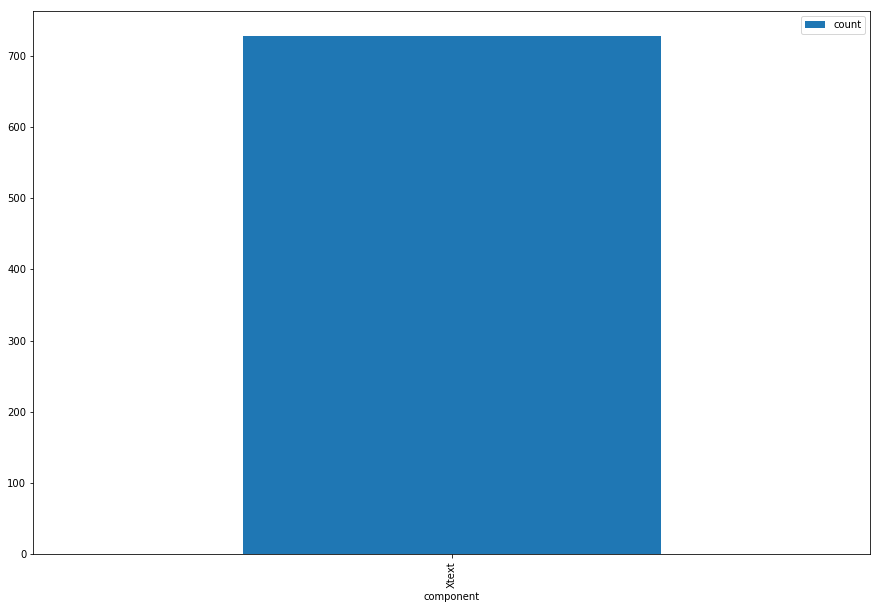

In [73]:
grouped = df.loc[:,['id','component']].groupby('component').count()
grouped.columns = ['count']
grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
plt.show()

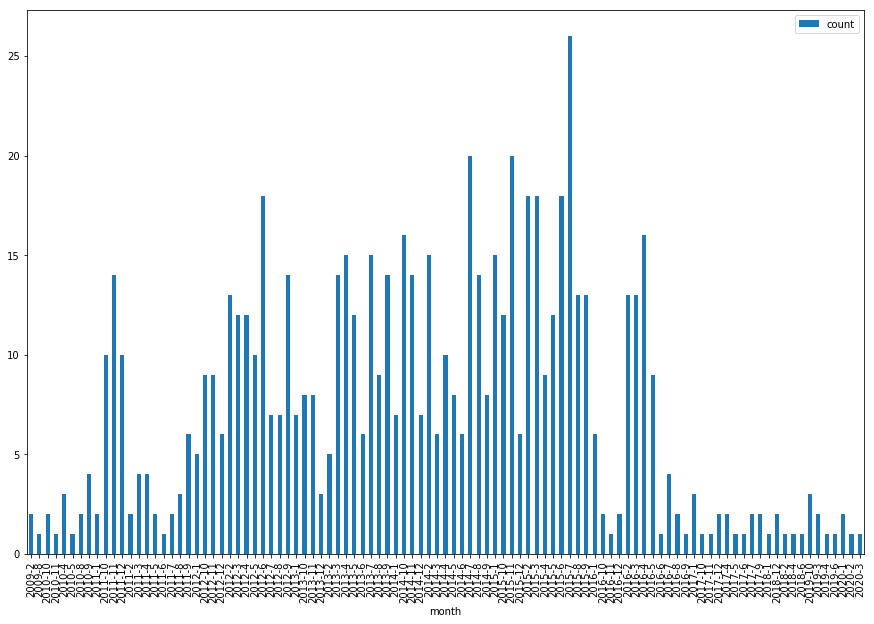

In [74]:
grouped = df.loc[:,['id','month']].groupby('month').count()
grouped.columns = ['count']
grouped.plot(kind='bar',figsize=(15,10))
plt.show()

1.0
64.7199999999998
                  count
reporter               
42r_3b2qej8pytbx      1
nicolas.lalevee       1
neerajbhusare         1
mitchell.schrock      1
milesparker           1
                    count
reporter                 
jan.koehnlein          34
sven.efftinge          56
ed                     59
moritz.eysholdt        81
sebastian.zarnekow     88


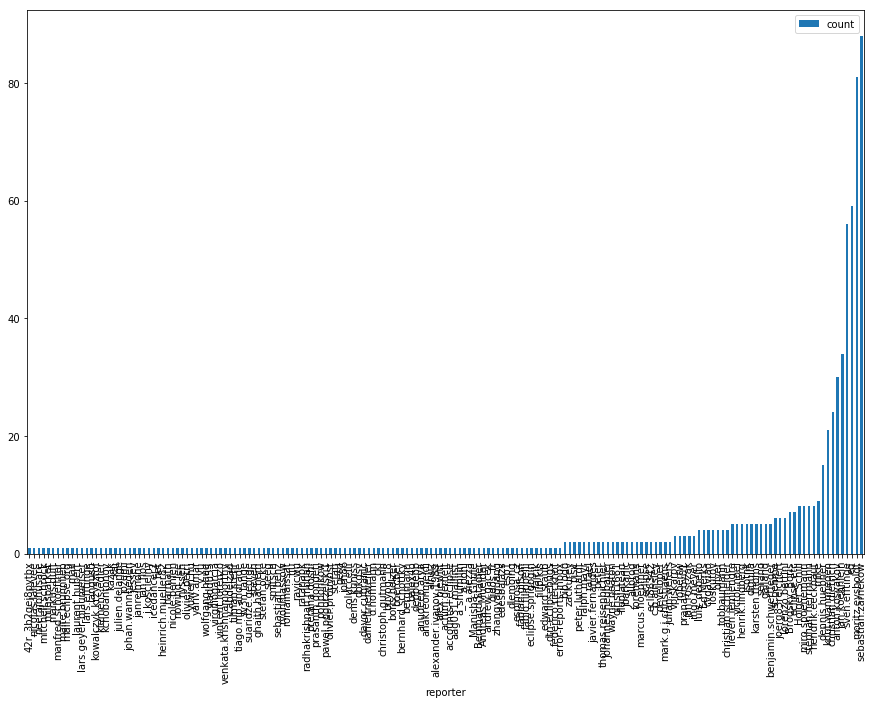

In [8]:
grouped = df.loc[:,['id','reporter']].groupby('reporter').count()
grouped.columns = ['count']
# Find the values bounding the 98 percentile
# May want to filter these later
print(np.percentile(grouped.loc[:,'count'].values, 1))
print(np.percentile(grouped.loc[:,'count'].values, 99))

sorted = grouped.sort_values(by='count')
print(sorted.head())
print(sorted.tail())

sorted.plot(kind='bar', figsize=(15,10))
plt.show()


Accepting values between  71.03999999999999  and  34149.76000000001


/opt/tools/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


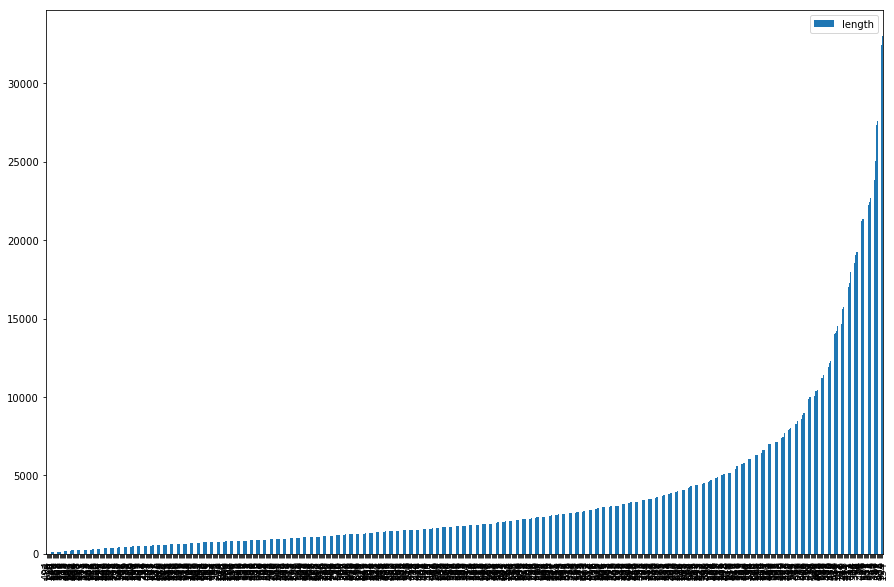

In [9]:
df['length'] = df['text'].str.len()
# Find the values bounding the 98 percentile
# May want to filter these later
one_percent = np.percentile(df.loc[:,'length'].values, 1)
ninety_nine_percent = np.percentile(df.loc[:,'length'].values, 99)
print('Accepting values between ', one_percent, ' and ', ninety_nine_percent)

trimmedDF = df[df['length'] > one_percent][df['length'] < ninety_nine_percent]
trimmedDF.loc[:,['id','length']].sort_values(by='length').plot(kind='bar', figsize=(15,10))

plt.show()

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [10]:
exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in text.split(' '):
        if re.fullmatch('[a-zA-Z]+', token):
            filtered_tokens.append(token)
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0

for i in trimmedDF.loc[:,'text']:
    count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
    if count > 20:
        break
print('Total word count: '+str(len(totalvocab)))
    

Total word count: 13063


# Create a TF/IDF Matrix

We'll use the sklearn TfidfVectorizer to build the matrix. For this case, we will use the noun/verb tokenizer to get a list of words from each bug.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.25,
                                   min_df=2,
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize)

#%time tfidf_matrix = tfidf_vectorizer.fit_transform(bug_text) #fit the vectorizer to synopses
%time tfidf_matrix = tfidf_vectorizer.fit_transform(trimmedDF.loc[:,'text']) #fit the vectorizer to synopses
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


CPU times: user 4.02 s, sys: 4.09 ms, total: 4.02 s
Wall time: 4.02 s


# Create a CountVectorizer


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.25, min_df=2, stop_words='english', tokenizer=tokenize)
%time tf = tf_vectorizer.fit_transform(trimmedDF.loc[:,'text'])
tf_feature_names = tf_vectorizer.get_feature_names()


CPU times: user 4.22 s, sys: 0 ns, total: 4.22 s
Wall time: 4.23 s


In [13]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Run NMF
%time nmf = NMF(n_components=7, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)

# Run LDA
%time lda = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

num_words = 5

print('\nNMF Topics: ')
for topic_idx, topic in enumerate(nmf.components_):
    print ("Topic %d:" % (topic_idx), " ".join([tfidf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

print('\nLDA Topics: ')

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx), " ".join([tf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))



CPU times: user 840 ms, sys: 19.7 ms, total: 860 ms
Wall time: 226 ms
CPU times: user 6.53 s, sys: 92 ms, total: 6.62 s
Wall time: 1.69 s

NMF Topics: 
Topic 0: project new build eclipse comment
Topic 1: type reference infer parameter inferred
Topic 2: grammar rule ecore model returns
Topic 3: editor open text file opened
Topic 4: extends static def void string
Topic 5: attachment created attached rename refactoring
Topic 6: content assist does xbase proposals

LDA Topics: 
Topic 0: api string new implementation syntax
Topic 1: build comment file project reply
Topic 2: editor open text content editors
Topic 3: rule grammar element elements tokens
Topic 4: grammar var bug event duplicate
Topic 5: type jobs reference ecore uris
Topic 6: grammar code generated type new


In [14]:
def getLDATopic(row):
    tf_text = tf_vectorizer.transform([row['text']])
    doc_topic_dist = np.matrix(lda.transform(tf_text))
    #quick and dirty for now. May need to check for separation of values
    return doc_topic_dist.argmax()
            
%time trimmedDF['topic'] = trimmedDF.apply(getLDATopic, axis=1)


CPU times: user 6.15 s, sys: 31.7 ms, total: 6.18 s
Wall time: 4.65 s


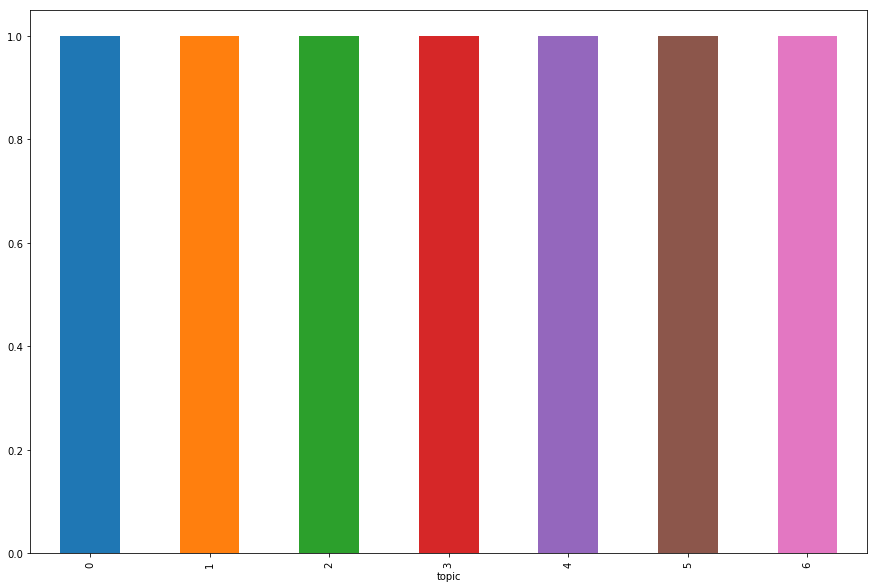

In [15]:
grouped = trimmedDF.loc[:,['id','component','topic']].groupby('topic').component.nunique()
grouped.columns = ['count', 'component']
# grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
grouped.sort_values().plot(kind='bar', figsize=(15,10))
plt.show()



# Create a 2D Visualization

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

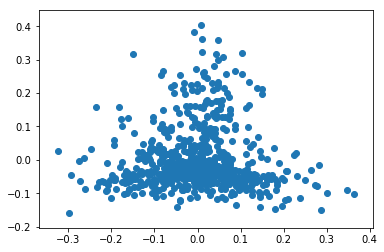

In [16]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = tfidf_matrix.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.show()


# I'll have another

Now try the same thing with MDS for reducing to 2 dimensions.

CPU times: user 30.4 s, sys: 456 ms, total: 30.9 s
Wall time: 7.75 s


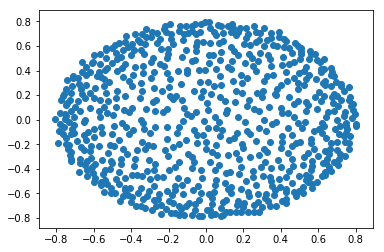

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
plt.scatter(pos[:,0], pos[:,1])

plt.show()
xs, ys = pos[:, 0], pos[:, 1]


# Find Nearest Neighbors

Using the TF/IDF Matrix, find the nearest neighbors for each bug. Print out a random sample with links to spot check. Also plot the distance to the nearest neighbor to visualize the distribution.

CPU times: user 2.23 ms, sys: 43 µs, total: 2.28 ms
Wall time: 486 µs
Distanance to nearest neighbor (Mean/StdDev/Min/Max): (1.21/0.08/0.60/1.35) 


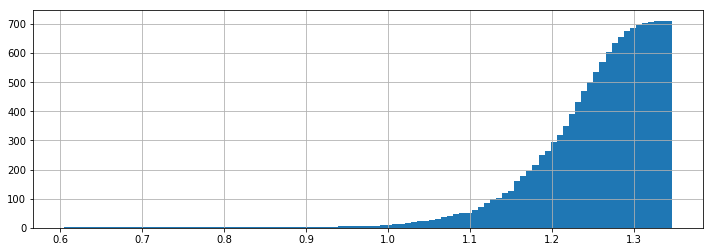

In [18]:
from sklearn.neighbors import NearestNeighbors

%time nbrs = NearestNeighbors().fit(tfidf_matrix)
distances, indices = nbrs.kneighbors(tfidf_matrix)

indicesDF = pd.DataFrame(indices)
sample = indicesDF.sample(5)

# Need to use trimmedDF to properly get bug id
# print('Check the following bugs for relatedness...')
# for row in sample.values:
#     print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[0]]))
#     #print(noun_verb(bug_text[row[0]]))
#     print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[1]]))
#     #print(noun_verb(bug_text[row[1]]))
#     print()
distancesDF = pd.DataFrame(distances)

# Slice the distances returned to get the column of the nearest neighbor
nearest = distancesDF.iloc[:, 1]
print('Distanance to nearest neighbor (Mean/StdDev/Min/Max): (%0.2f/%0.2f/%0.2f/%0.2f) ' % (np.mean(nearest), np.std(nearest),
     np.min(nearest), np.max(nearest)))
nearest.hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

labels = km.labels_

# May be meaningful if we knew what the labels should be
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
# print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
# print("Adjusted Rand-Index: %.3f"
#       % metrics.adjusted_rand_score(labels, km.labels_))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(tfidf_matrix, km.labels_, sample_size=1000))



CPU times: user 13.6 s, sys: 168 ms, total: 13.8 s
Wall time: 3.47 s


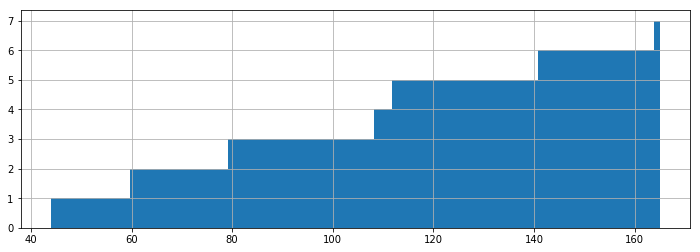

In [20]:
clusters = km.labels_.tolist()
bugs = { 'title': trimmedDF.loc[:,'title'], 'text': trimmedDF.loc[:,'text'], 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [21]:
print("Top term per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

top_term = []
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    
    for ind in order_centroids[i, :1]:
        #print(bug_titles[ind])
        print(terms[ind])
        top_term.append(terms[ind])
        #print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[ind]))
        #top_term.append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])


Top term per cluster:

Cluster 0:build
Cluster 1:class
Cluster 2:generated
Cluster 3:type
Cluster 4:rule
Cluster 5:resource
Cluster 6:grammar


/opt/tools/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


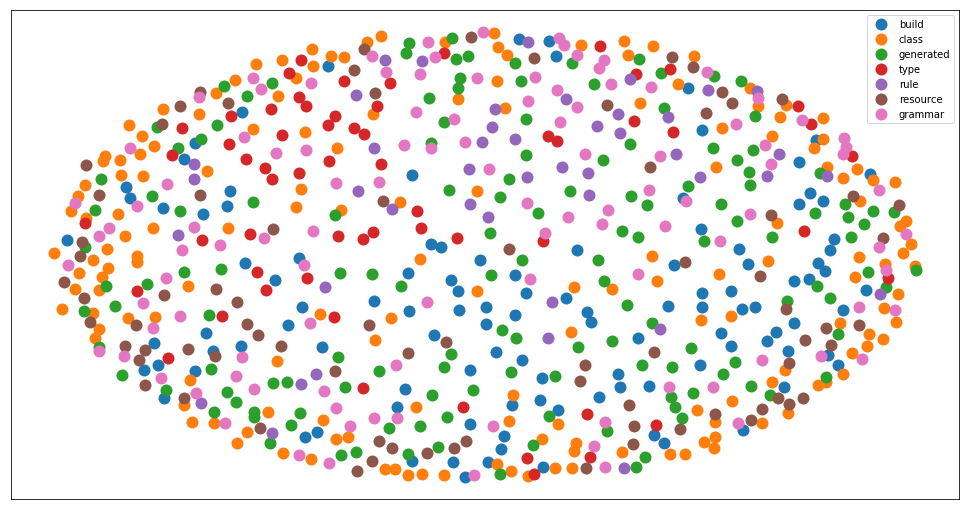

In [22]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'],)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


In [23]:
xs, ys = data2D[:, 0], data2D[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


ValueError: arrays must all be same length

In [24]:
from sklearn.cluster import DBSCAN

# May be able to calculate this number based on the output from the nearest neighbor search.
# Units relate to the data being fit
epsilon = 0.92


db = DBSCAN(eps=epsilon, min_samples=10)

%time db.fit(tfidf_matrix)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % num_clusters)

CPU times: user 32.6 ms, sys: 83 µs, total: 32.7 ms
Wall time: 18 ms
Estimated number of clusters: 0


In [25]:
clusters = db.labels_.tolist()
bugs = { 'title': bug_titles, 'text': bug_text, 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

ValueError: Shape of passed values is (2, 727), indices imply (2, 711)

In [26]:
xs, ys = pos[:, 0], pos[:, 1]
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
            label=name,
#            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot

ValueError: arrays must all be same length

# Create a Verb/Noun Tokenize Method

This method provides another step of filtering to return only words that are nouns or verbs. We will go ahead and run this against the bugs that we have loaded to find the total number of noun/verbs.


In [58]:
import spacy

nlp = spacy.load('en_core_web_sm')
filter = ['VERB', 'NOUN', 'PROPN']
def noun_verb(text):
    filtered_tokens = []
    doc = nlp(text)
    for sent in doc.sents:
        
        # Bugzilla has a tendency to place inline comments in the form of:
        # > Previous Text
        # This will cause a duplicate if not removed.
        if not re.match('^> ', str(sent)):
            for token in sent:
                if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                    filtered_tokens.append(token.text)
    #    else:
    #        print('>Match')
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0
for i in bug_text:
    count = count+1
    allwords = noun_verb(i)
    totalvocab.extend(allwords)
    if count > 20:
        print(count)
        break;
print('Total verb/noun count: '+str(len(totalvocab)))

21
Total verb/noun count: 17325


In [56]:
#Exception
#doc = nlp(bug_text[2])

#Reply
print(bug_ids[19])
print(bug_text[19])
doc = nlp(bug_text[19])
for sent in doc.sents:
    if re.match('^> ', str(sent)):
        print('>Match')
#    print("Sentence->")
#    print(sent)
    if re.match('.+Exception[^\n].*\s+at', str(sent)):
        print('Match!')

508455
Contexts Model Editor error when trying to select datacontext of a view I have a context file open with the Contexts Model Editor.
I select a view.
When I try to set the datacontexts field of the view the editor show numerous errors messages and freeze.

See attachmment.

Thank you. Hi there is no attachment Created attachment 267197
Screenshot Comment on attachment 267197
Screenshot

Arf sorry, here it is. I have a context file open with the Contexts Model Editor.
I select a view.
When I try to set the datacontexts field of the view the editor show numerous errors messages and freeze.

See attachmment.

Thank you. Hi there is no attachment Created attachment 267197
Screenshot Comment on attachment 267197
Screenshot

Arf sorry, here it is.


NameError: name 'nlp' is not defined

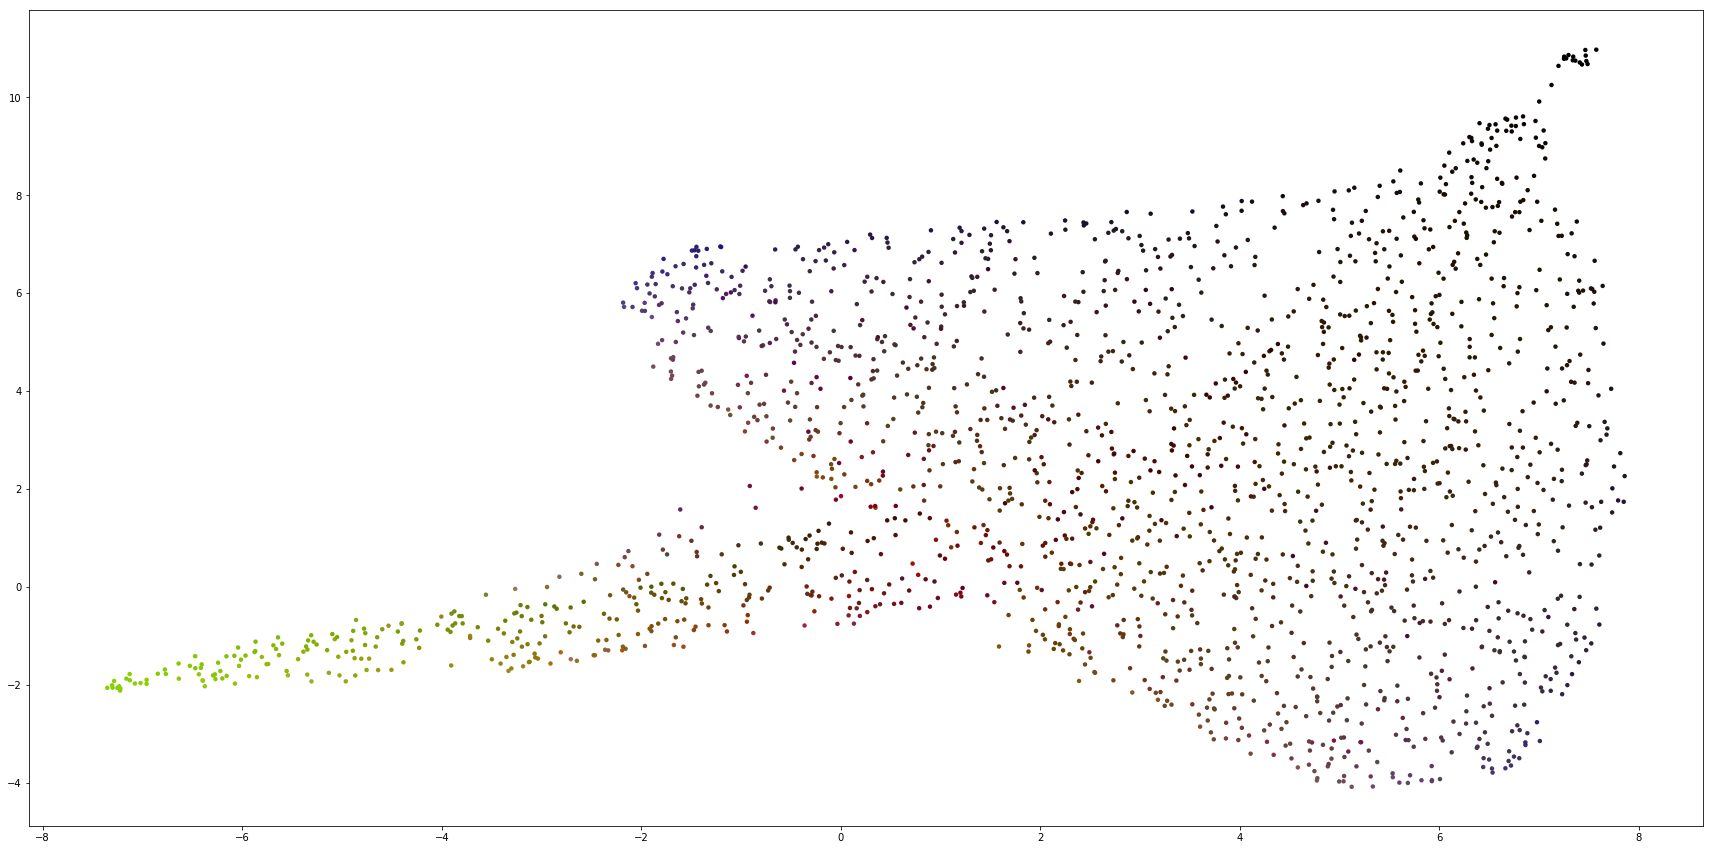

In [54]:
from sklearn.decomposition import TruncatedSVD 
import umap 

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122) 
X_topics = svd_model.fit_transform(tfidf_matrix) 
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics) 

colors = []
for x,y,z in X_topics:
    colors.append((abs(x), abs(y), abs(z)))
    
plt.figure(figsize=(30,15)) 
i = 0;
for em in embedding:
    plt.scatter(em[0], em[1],
        c = colors[i],
        s = 20, # size 
        edgecolor='none' )
    i = i+1
plt.show()